In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
# Suppress warnings
import warnings; warnings.filterwarnings('ignore')


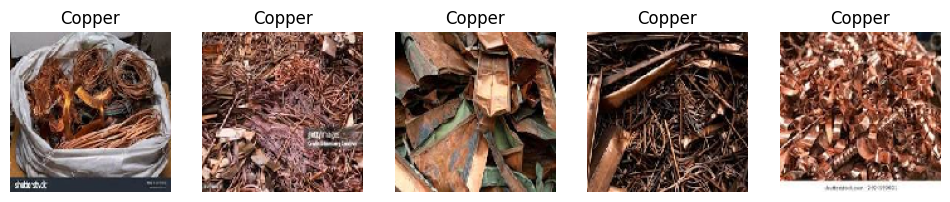

In [2]:
# Define the directory where images are stored
image_directory = "e-copper_waste_dataset"

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in glob.glob(os.path.join(folder, "*.jpg")):
        img = load_img(filename, target_size=(128, 128))
        img_array = img_to_array(img)
        images.append(img_array)
        
        # Assign labels based on filename prefix
        if 'Copper' in filename:
            labels.append(1)  # Copper label
        elif 'Organic_waste' in filename:
            labels.append(0)  # Organic waste label
    return np.array(images), np.array(labels)

# Load images and labels
X, y = load_images_from_folder(image_directory)

# Normalize pixel values to be between 0 and 1
X = X / 255.0

# Display the first 5 images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title('Copper' if y[i] == 1 else 'Organic Waste')
    plt.axis('off')
plt.show()


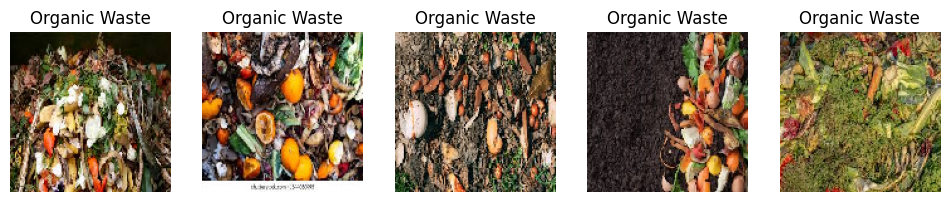

In [3]:
# Display the first 5 Organic Waste images
organic_waste_indices = np.where(y == 0)[0]  # Get indices of Organic Waste images

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[organic_waste_indices[i]])
    plt.title('Organic Waste')
    plt.axis('off')
plt.show()


In [4]:
# Basic statistics on image data
num_copper_images = np.sum(y == 1)
num_organic_waste_images = np.sum(y == 0)

print(f'Number of copper images: {num_copper_images}')
print(f'Number of organic waste images: {num_organic_waste_images}')

# Example of shape and dtype of the images
print(f'Image shape: {X[0].shape}')
print(f'Image data type: {X[0].dtype}')



Number of copper images: 8
Number of organic waste images: 8
Image shape: (128, 128, 3)
Image data type: float32


In [5]:
# Create labels: 1 for copper, 0 for organic waste
copper_labels = np.ones(np.sum(y == 1))
organic_labels = np.zeros(np.sum(y == 0))

# Combine data and labels
X = np.concatenate((X[y == 1], X[y == 0]), axis=0)
y = np.concatenate((copper_labels, organic_labels), axis=0)

print(f'Total number of images: {len(X)}')
print(f'Total number of labels: {len(y)}')

# Basic statistics on image data
num_copper_images = np.sum(y == 1)
num_organic_waste_images = np.sum(y == 0)

print(f'Number of copper images: {num_copper_images}')
print(f'Number of organic waste images: {num_organic_waste_images}')

# Example of shape and dtype of the images
print(f'Image shape: {X[0].shape}')
print(f'Image data type: {X[0].dtype}')


Total number of images: 16
Total number of labels: 16
Number of copper images: 8
Number of organic waste images: 8
Image shape: (128, 128, 3)
Image data type: float32


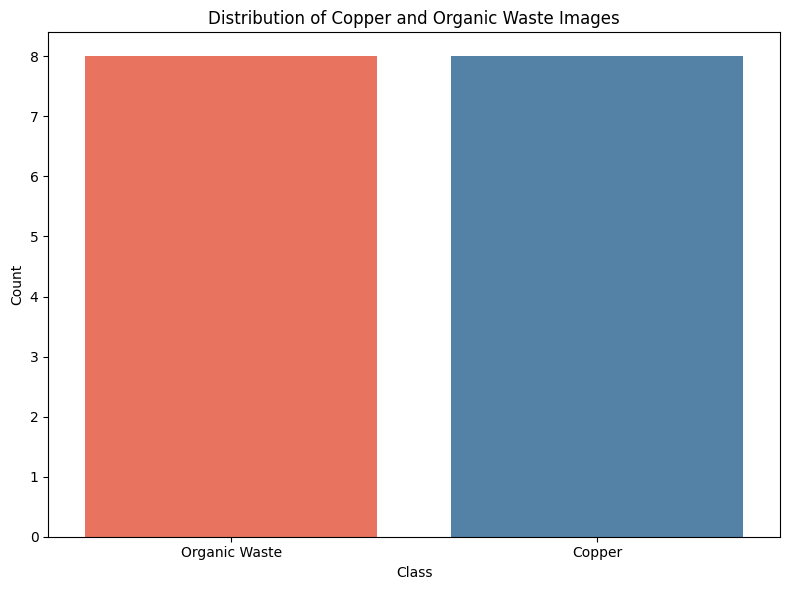

In [6]:
# Enhanced visualization of the distribution of classes with labels for the x-axis
plt.figure(figsize=(8, 6))
sns.countplot(x=y, hue=y, palette=['#FF6347', '#4682B4'], legend=False)  # Use different colors for the classes
plt.title('Distribution of Copper and Organic Waste Images')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Organic Waste', 'Copper'])
plt.tight_layout()  # Adjust the layout to prevent label cut-off
plt.show()


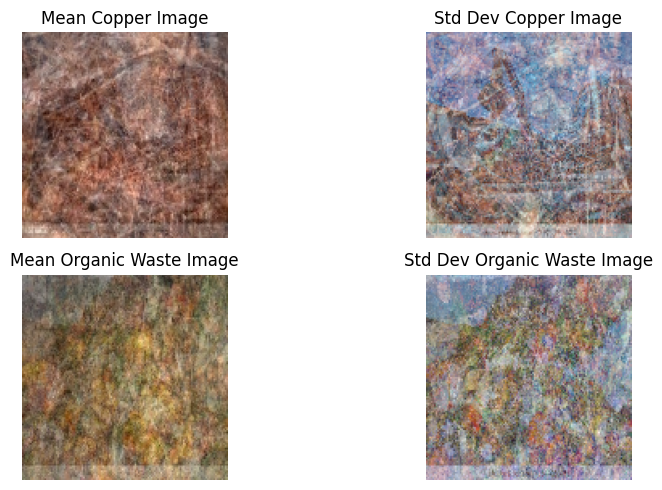

In [7]:
# Calculate mean and standard deviation of the images for each class
mean_copper = np.mean(X[y == 1], axis=0)
std_copper = np.std(X[y == 1], axis=0)
mean_organic = np.mean(X[y == 0], axis=0)
std_organic = np.std(X[y == 0], axis=0)

# Normalize mean images for better visualization
mean_copper_normalized = (mean_copper - mean_copper.min()) / (mean_copper.max() - mean_copper.min()) * 255
mean_organic_normalized = (mean_organic - mean_organic.min()) / (mean_organic.max() - mean_organic.min()) * 255

# Scale standard deviation for better visualization
std_copper_scaled = std_copper / std_copper.max() * 255
std_organic_scaled = std_organic / std_organic.max() * 255

# Display the mean and standard deviation images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(mean_copper_normalized.astype(np.uint8))
plt.title('Mean Copper Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(std_copper_scaled.astype(np.uint8), cmap='gray')
plt.title('Std Dev Copper Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mean_organic_normalized.astype(np.uint8))
plt.title('Mean Organic Waste Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(std_organic_scaled.astype(np.uint8), cmap='gray')
plt.title('Std Dev Organic Waste Image')
plt.axis('off')

plt.tight_layout()
plt.show()


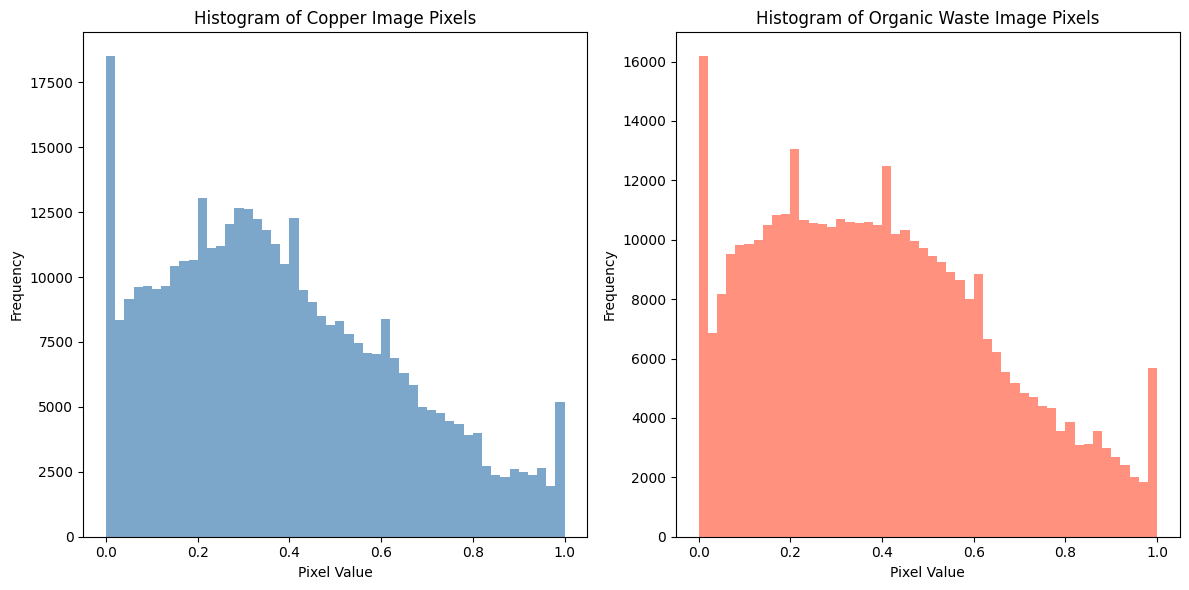

In [8]:
# Flatten images for histogram
copper_flat = X[y == 1].flatten()
organic_flat = X[y == 0].flatten()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(copper_flat, bins=50, color='#4682B4', alpha=0.7)
plt.title('Histogram of Copper Image Pixels')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(organic_flat, bins=50, color='#FF6347', alpha=0.7)
plt.title('Histogram of Organic Waste Image Pixels')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


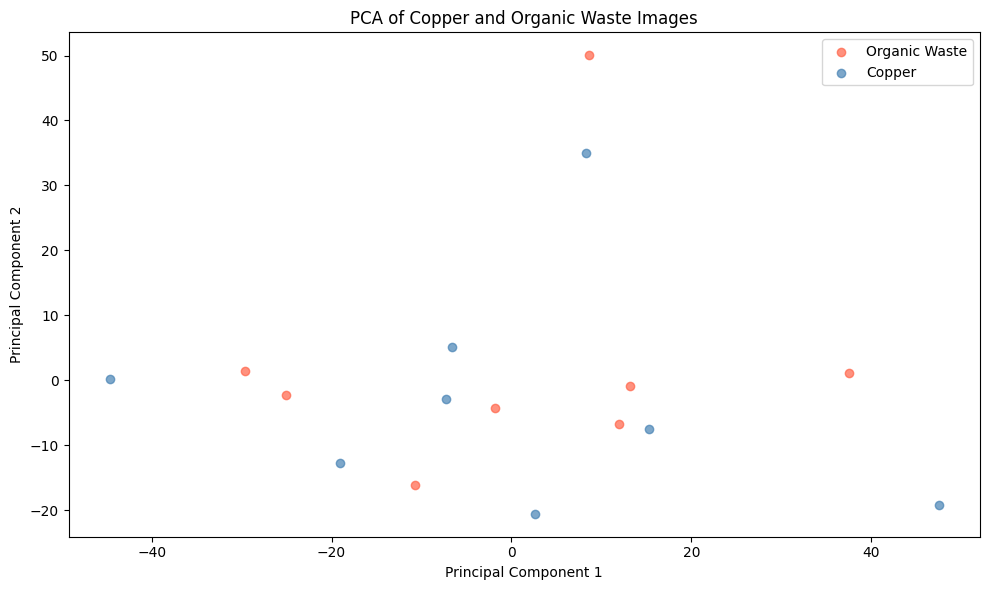

In [9]:
from sklearn.decomposition import PCA
# Reshape images for PCA
X_flat = X.reshape(len(X), -1)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], label='Organic Waste', alpha=0.7, color='#FF6347')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], label='Copper', alpha=0.7, color='#4682B4')
plt.title('PCA of Copper and Organic Waste Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.show()


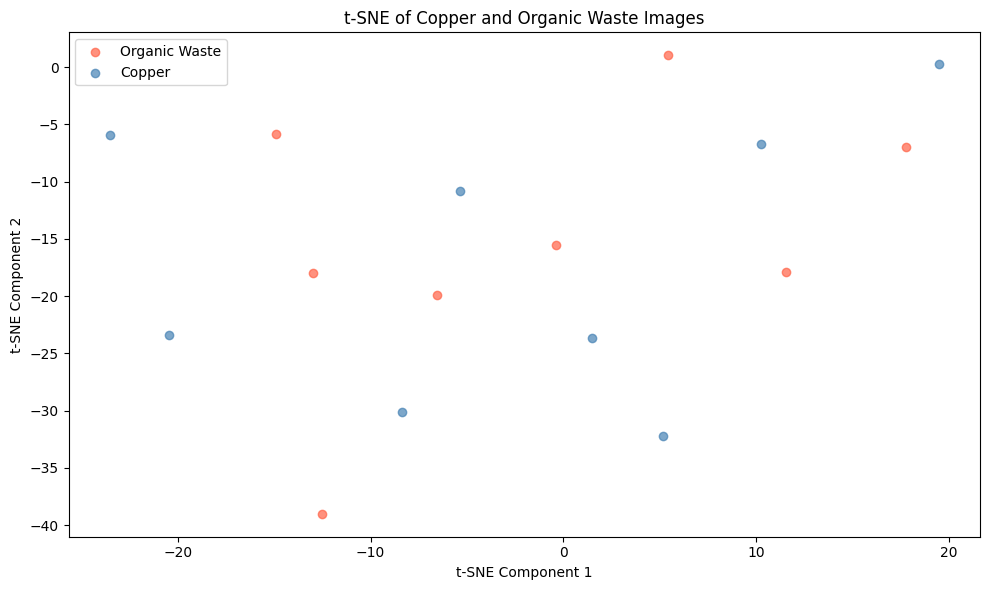

In [10]:
from sklearn.manifold import TSNE

# Check the number of samples
n_samples = len(X_flat)

# Apply t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=min(5, n_samples - 1), random_state=42)
X_tsne = tsne.fit_transform(X_flat)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], label='Organic Waste', alpha=0.7, color='#FF6347')
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], label='Copper', alpha=0.7, color='#4682B4')
plt.title('t-SNE of Copper and Organic Waste Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.show()


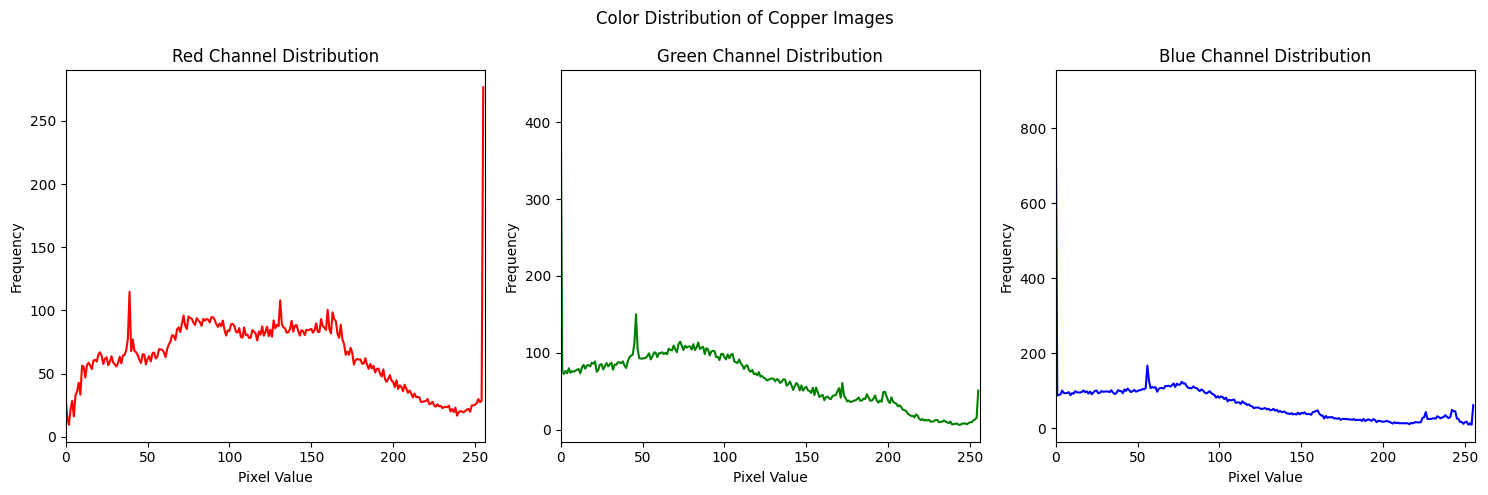

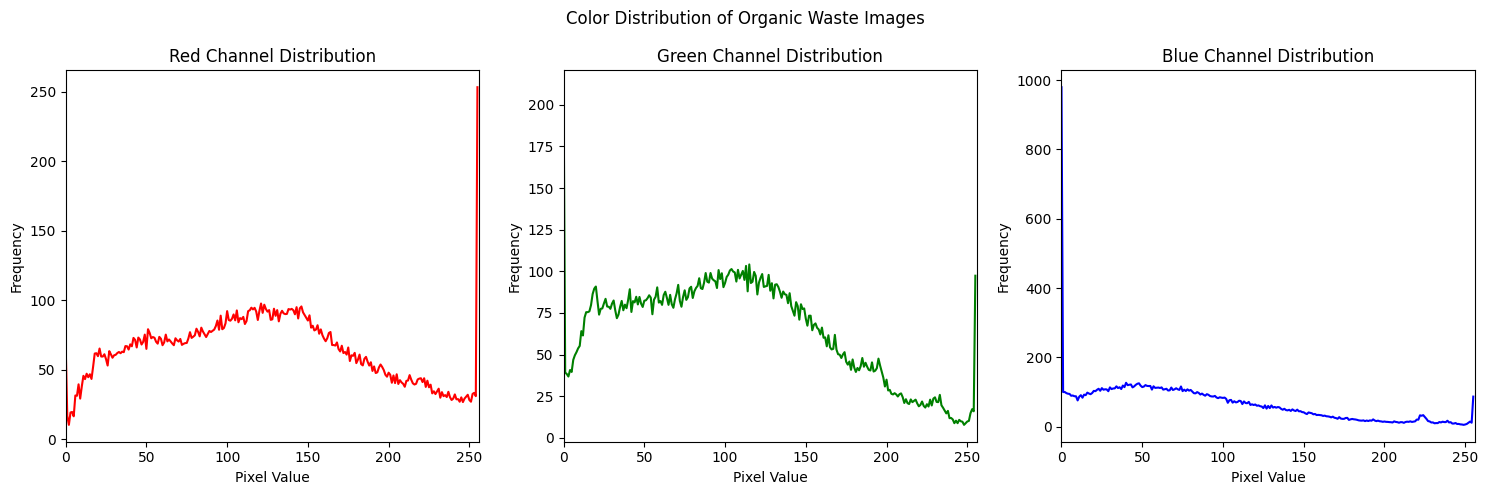

In [11]:
# Function to calculate and plot color distribution
def plot_color_distribution(images, title):
    colors = ('r', 'g', 'b')
    channels = ('Red', 'Green', 'Blue')
    
    plt.figure(figsize=(15, 5))
    
    for i, color in enumerate(colors):
        hist = np.zeros(256)
        for img in images:
            img_uint8 = (img * 255).astype(np.uint8)  # Ensure the image is in uint8 format
            channel_data = img_uint8[:, :, i]
            hist += cv2.calcHist([channel_data], [0], None, [256], [0, 256]).flatten()
        hist /= len(images)
        
        plt.subplot(1, 3, i + 1)
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
        plt.title(f'{channels[i]} Channel Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot color distribution for copper images
plot_color_distribution(X[y == 1], 'Color Distribution of Copper Images')

# Plot color distribution for organic waste images
plot_color_distribution(X[y == 0], 'Color Distribution of Organic Waste Images')


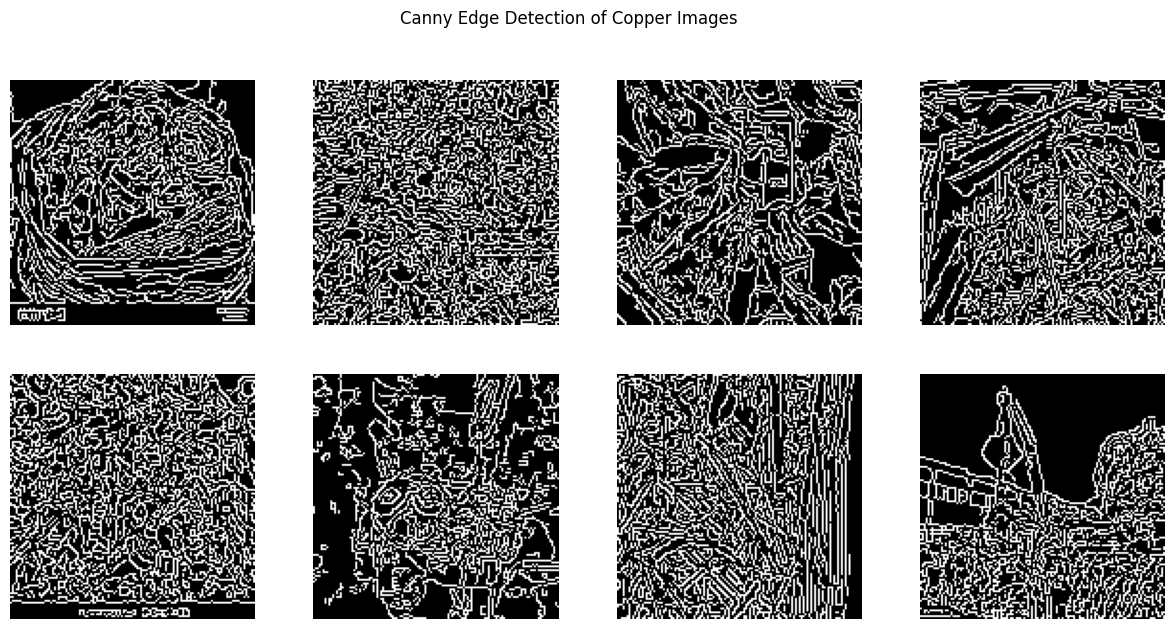

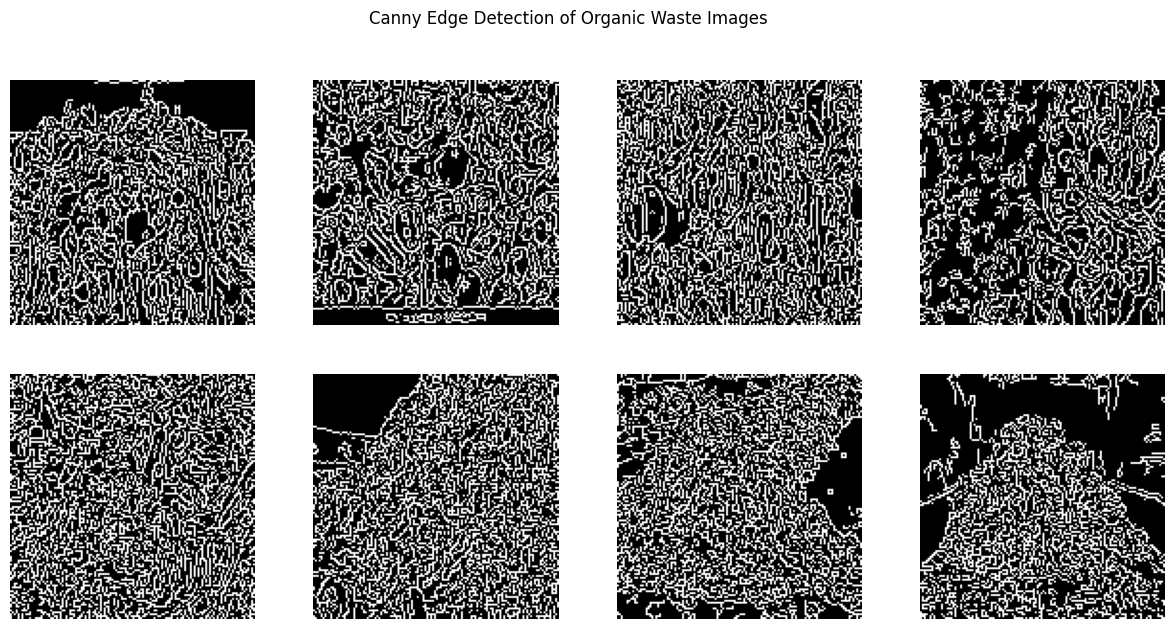

In [12]:
# Function to apply Canny edge detection and display images
def plot_edges(images, title):
    plt.figure(figsize=(15, 7))
    for i in range(min(len(images), 8)):  # Display up to 8 images
        img_uint8 = (images[i] * 255).astype(np.uint8)  # Ensure the image is in uint8 format
        edges = cv2.Canny(img_uint8, 100, 200)
        plt.subplot(2, 4, i + 1)
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot edges for copper images
plot_edges(X[y == 1], 'Canny Edge Detection of Copper Images')

# Plot edges for organic waste images
plot_edges(X[y == 0], 'Canny Edge Detection of Organic Waste Images')


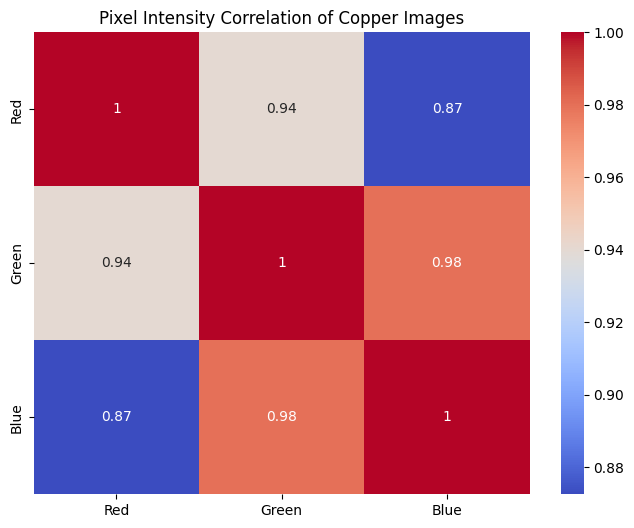

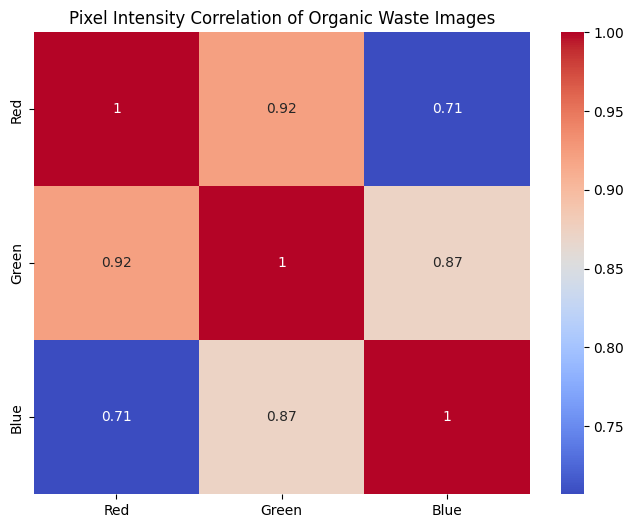

In [13]:
# Function to compute and plot pairwise pixel intensity correlation
def plot_pixel_intensity_correlation(images, title):
    image = np.mean(images, axis=0)
    channels = ['Red', 'Green', 'Blue']
    corr_matrix = np.corrcoef(image.reshape(-1, 3), rowvar=False)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=channels, yticklabels=channels)
    plt.title(title)
    plt.show()

# Plot pixel intensity correlation for copper images
plot_pixel_intensity_correlation(X[y == 1], 'Pixel Intensity Correlation of Copper Images')

# Plot pixel intensity correlation for organic waste images
plot_pixel_intensity_correlation(X[y == 0], 'Pixel Intensity Correlation of Organic Waste Images')


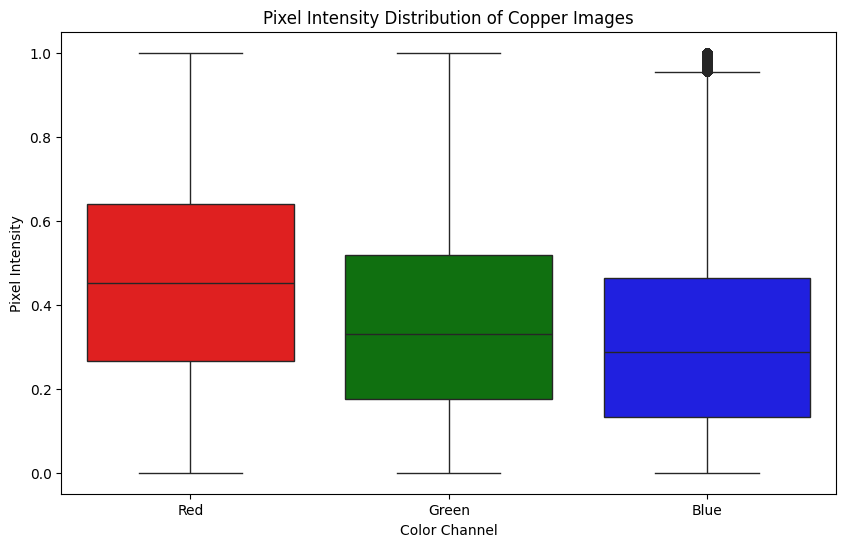

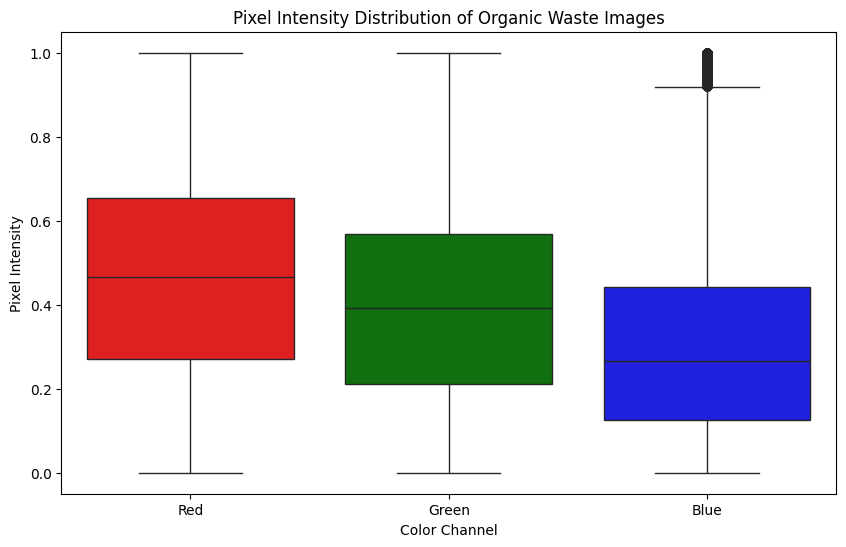

In [14]:
# Function to plot pixel intensity distribution using box plots
def plot_pixel_intensity_distribution(images, title):
    channels = ['Red', 'Green', 'Blue']
    pixel_values = {channel: [] for channel in channels}
    
    for img in images:
        for i, channel in enumerate(channels):
            pixel_values[channel].extend(img[:, :, i].flatten())
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[pixel_values[channel] for channel in channels], palette=channels)
    plt.title(title)
    plt.xlabel('Color Channel')
    plt.ylabel('Pixel Intensity')
    plt.xticks(ticks=[0, 1, 2], labels=channels)
    plt.show()

# Plot pixel intensity distribution for copper images
plot_pixel_intensity_distribution(X[y == 1], 'Pixel Intensity Distribution of Copper Images')

# Plot pixel intensity distribution for organic waste images
plot_pixel_intensity_distribution(X[y == 0], 'Pixel Intensity Distribution of Organic Waste Images')


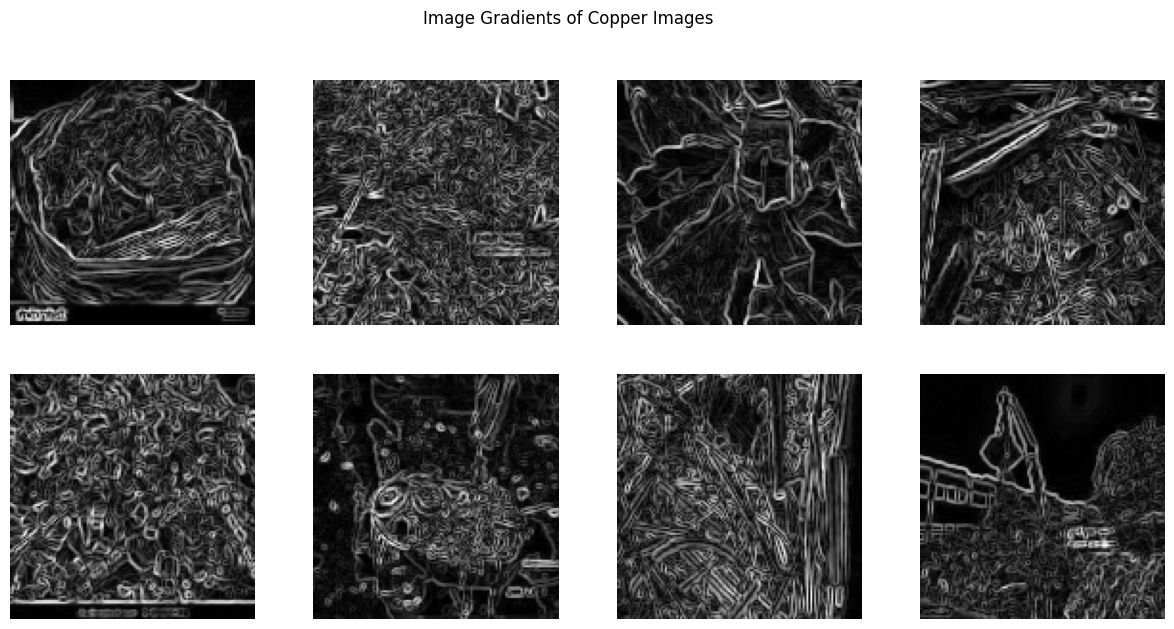

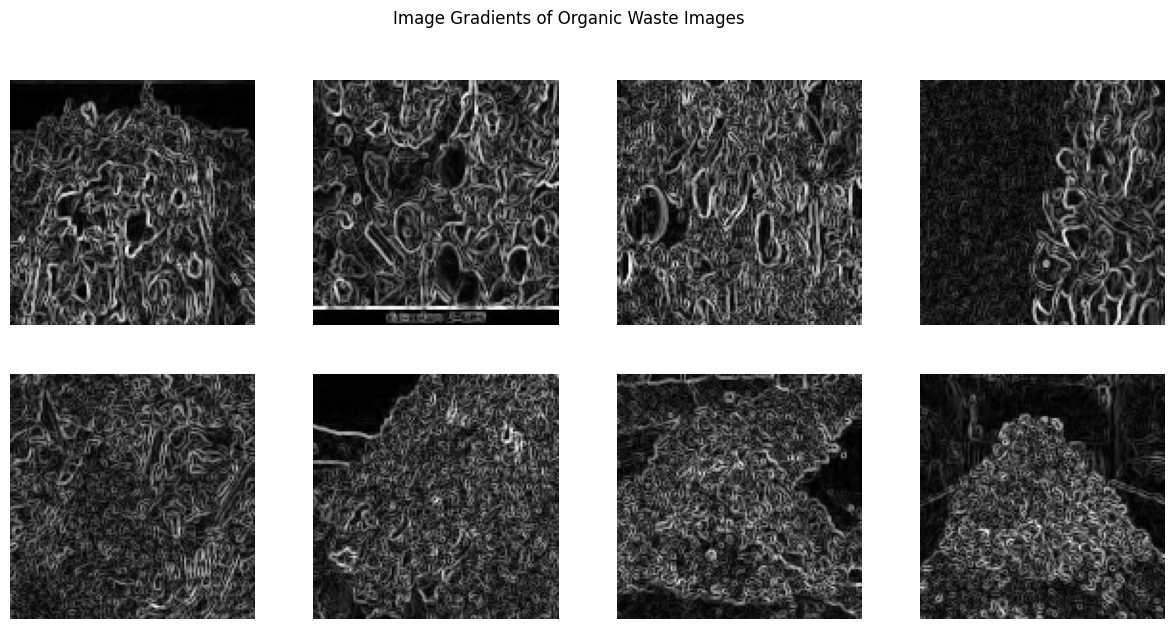

In [15]:
# Import the required module
from skimage.filters import sobel

# Function to compute and plot gradients
def plot_image_gradients(images, title):
    plt.figure(figsize=(15, 7))
    for i in range(min(len(images), 8)):  # Display up to 8 images
        gray_img = cv2.cvtColor((images[i] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        gradient = sobel(gray_img)
        plt.subplot(2, 4, i + 1)
        plt.imshow(gradient, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot gradients for copper images
plot_image_gradients(X[y == 1], 'Image Gradients of Copper Images')

# Plot gradients for organic waste images
plot_image_gradients(X[y == 0], 'Image Gradients of Organic Waste Images')


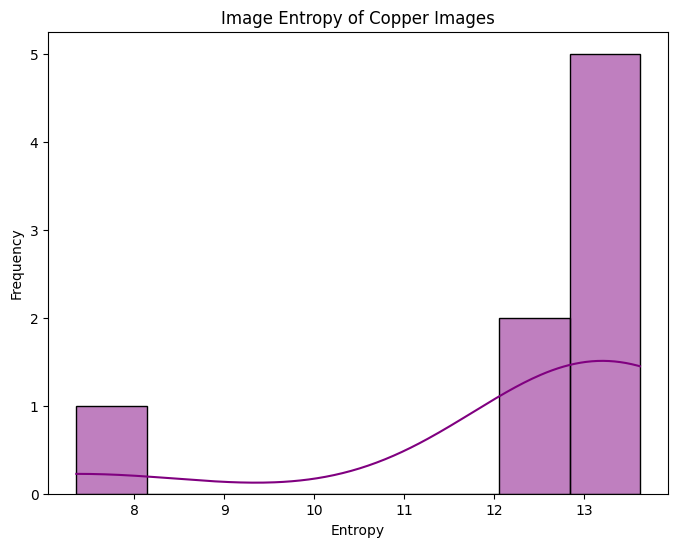

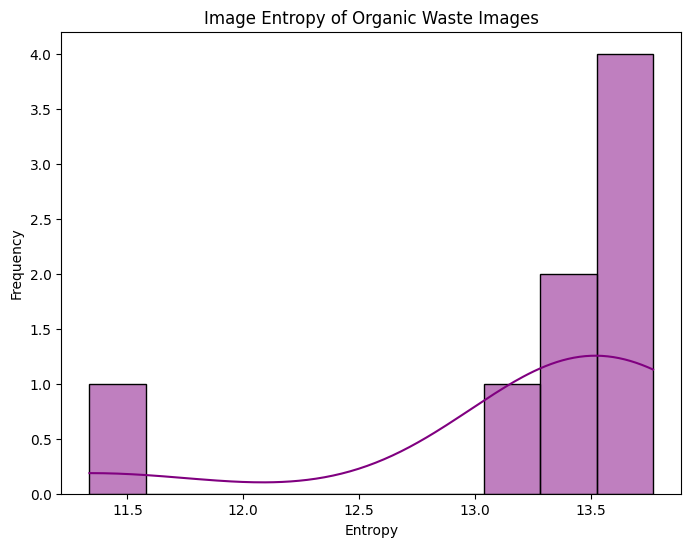

In [16]:
# Import the required module
from skimage.measure import shannon_entropy

# Function to compute and plot image entropy
def plot_image_entropy(images, title):
    entropies = [shannon_entropy(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) for img in images]
    
    plt.figure(figsize=(8, 6))
    sns.histplot(entropies, kde=True, color='purple')
    plt.title(title)
    plt.xlabel('Entropy')
    plt.ylabel('Frequency')
    plt.show()

# Plot entropy for copper images
plot_image_entropy(X[y == 1], 'Image Entropy of Copper Images')

# Plot entropy for organic waste images
plot_image_entropy(X[y == 0], 'Image Entropy of Organic Waste Images')



In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Create labels: 1 for copper, 0 for organic waste
copper_labels = np.ones(len(X[y == 1]))
organic_labels = np.zeros(len(X[y == 0]))

# Combine data and labels
X_combined = np.concatenate((X[y == 1], X[y == 0]), axis=0)
y_combined = np.concatenate((copper_labels, organic_labels), axis=0)

# Normalize pixel values to be between 0 and 1
X_combined = X_combined / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
history = model.fit(X_train, y_train_cat, epochs=15, validation_data=(X_test, y_test_cat))


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.2500 - val_loss: 0.6974
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6667 - loss: 0.6856 - val_accuracy: 0.2500 - val_loss: 0.7333
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6667 - loss: 0.6799 - val_accuracy: 0.2500 - val_loss: 0.8277
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6667 - loss: 0.6592 - val_accuracy: 0.2500 - val_loss: 0.8777
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6667 - loss: 0.7277 - val_accuracy: 0.2500 - val_loss: 0.7936
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6667 - loss: 0.6205 - val_accuracy: 0.2500 - val_loss: 0.7793
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5833 - loss: 0.6301 - val_accuracy: 0.2500 - val_loss: 0.7706
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5000 - loss: 0.6716 - val_accuracy: 0.2500 - val_loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2500 - loss: 0.7435
Test Accuracy: 25.00%


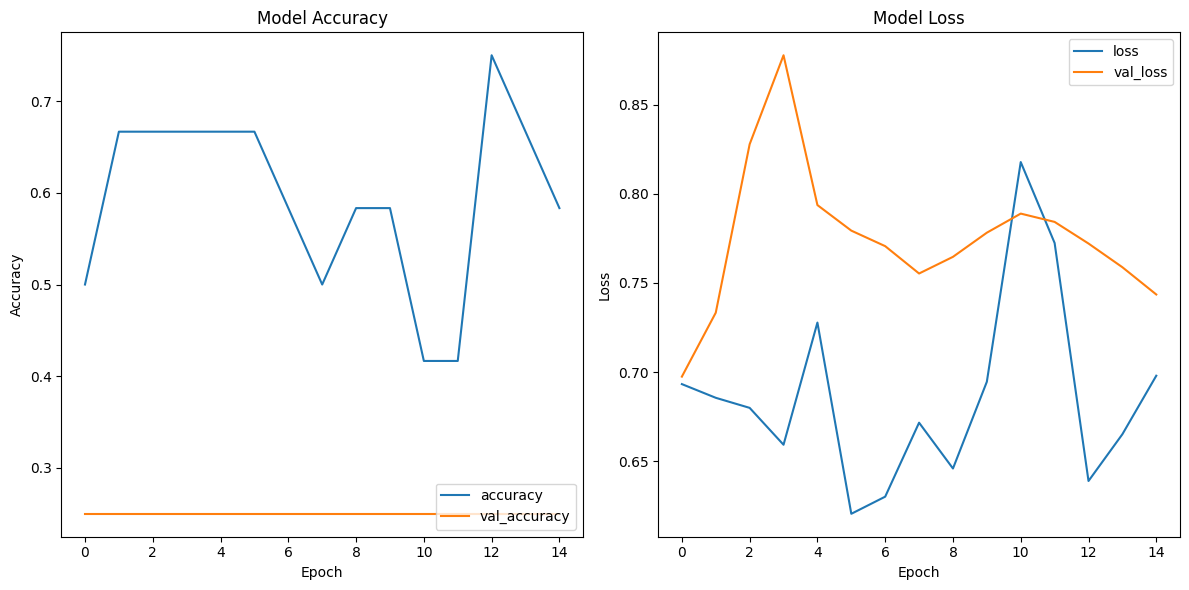

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


Number of images: 16
Image shape: (128, 128, 3)


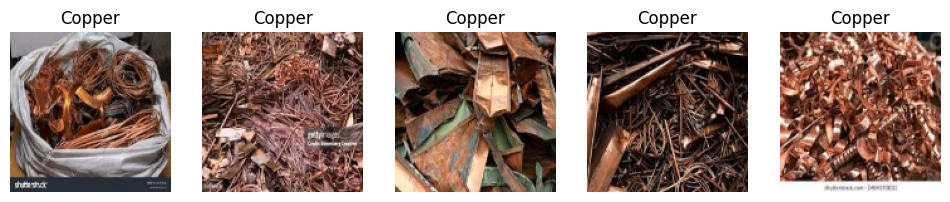

In [21]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to load and resize images from a directory
def load_images_from_directory(directory, size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, size)  # Resize to the target size
            images.append(img)
            
            # Assign labels based on filename prefix
            if 'Copper' in filename:
                labels.append(1)  # Copper label
            elif 'Organic_waste' in filename:
                labels.append(0)  # Organic waste label
    return np.array(images), np.array(labels)

# Define the directory where images are stored
image_directory = "e-copper_waste_dataset"

# Load images and labels
X, y = load_images_from_directory(image_directory)

# Verify the loaded images
print(f"Number of images: {len(X)}")
print(f"Image shape: {X[0].shape}")

# Display the first 5 images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title('Copper' if y[i] == 1 else 'Organic Waste')
    plt.axis('off')
plt.show()


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to save augmented images
def save_augmented_images(images, prefix, save_dir, num_augmented):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i, img in enumerate(images):
        img = img.reshape((1,) + img.shape)  # reshape to (1, height, width, channels)
        img_gen = datagen.flow(img, batch_size=1)
        
        for j in range(num_augmented):
            aug_img = next(img_gen)[0].astype(np.uint8)
            aug_img_path = os.path.join(save_dir, f"{prefix}_{i}_{j}.jpg")
            cv2.imwrite(aug_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))  # Save using OpenCV

# Directories to save augmented images
copper_save_dir = "augmented_copper"
organic_save_dir = "augmented_organic"

# Split the images based on labels
copper_imgs = X[y == 1]
organic_imgs = X[y == 0]

# Save augmented images
save_augmented_images(copper_imgs, "copper", copper_save_dir, num_augmented=100)
save_augmented_images(organic_imgs, "organic", organic_save_dir, num_augmented=100)


In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob

def load_augmented_images(augmented_dir, label):
    images = []
    labels = []
    for img_path in glob.glob(os.path.join(augmented_dir, "*.jpg")):
        img = load_img(img_path, target_size=(128, 128))
        img = img_to_array(img)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load augmented copper images
augmented_copper_imgs, augmented_copper_labels = load_augmented_images(copper_save_dir, 1)

# Load augmented organic waste images
augmented_organic_imgs, augmented_organic_labels = load_augmented_images(organic_save_dir, 0)

# Combine augmented data with original data
X_augmented = np.concatenate((X, augmented_copper_imgs, augmented_organic_imgs), axis=0)
y_augmented = np.concatenate((y, augmented_copper_labels, augmented_organic_labels), axis=0)

# Normalize pixel values to be between 0 and 1
X_augmented = X_augmented / 255.0

# Split augmented data into training and testing sets
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train_aug_cat = to_categorical(y_train_aug, 2)
y_test_aug_cat = to_categorical(y_test_aug, 2)


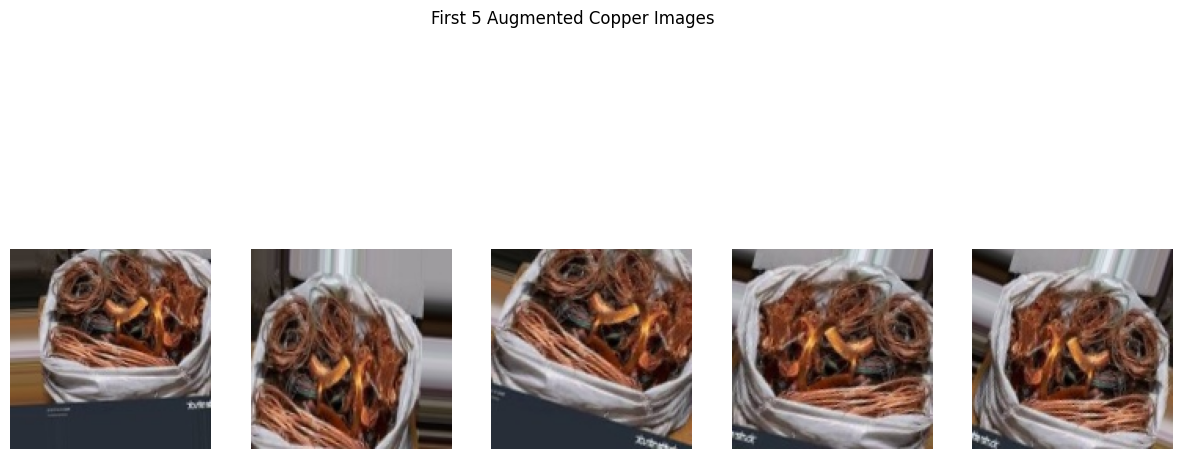

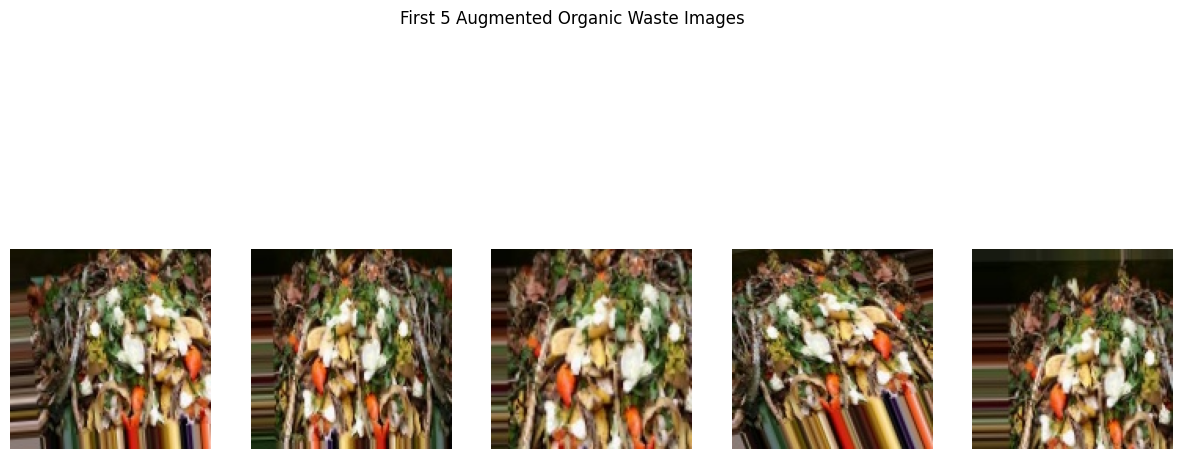

In [24]:
# Function to preview the first 5 images
def preview_augmented_images(images, title):
    plt.figure(figsize=(15, 7))
    for i in range(min(len(images), 5)):  # Display up to 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].astype(np.uint8))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Preview augmented copper images
preview_augmented_images(augmented_copper_imgs, 'First 5 Augmented Copper Images')

# Preview augmented organic waste images
preview_augmented_images(augmented_organic_imgs, 'First 5 Augmented Organic Waste Images')


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model with dropout layers for regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model with augmented data
history = model.fit(X_train_aug, y_train_aug_cat, epochs=20, validation_data=(X_test_aug, y_test_aug_cat))


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 598ms/step - accuracy: 0.5536 - loss: 1.1279 - val_accuracy: 0.8426 - val_loss: 0.4512
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 433ms/step - accuracy: 0.9041 - loss: 0.2975 - val_accuracy: 0.8796 - val_loss: 0.2491
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - accuracy: 0.9748 - loss: 0.0832 - val_accuracy: 1.0000 - val_loss: 0.0148
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 0.9992 - loss: 0.0160 - val_accuracy: 0.9815 - val_loss: 0.0399
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 430ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 550ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 429ms/step - accuracy: 1.0000 - loss: 8.7630e-04 - val_accuracy: 1.0000 - val_loss: 7.4766e-04
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 1.0000 - loss: 5.6734e-0

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.1714e-04
Test Accuracy: 100.00%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Classification Report:
               precision    recall  f1-score   support

Organic Waste       1.00      1.00      1.00       152
       Copper       1.00      1.00      1.00       172

     accuracy                           1.00       324
    macro avg       1.00      1.00      1.00       324
 weighted avg       1.00      1.00      1.00       324



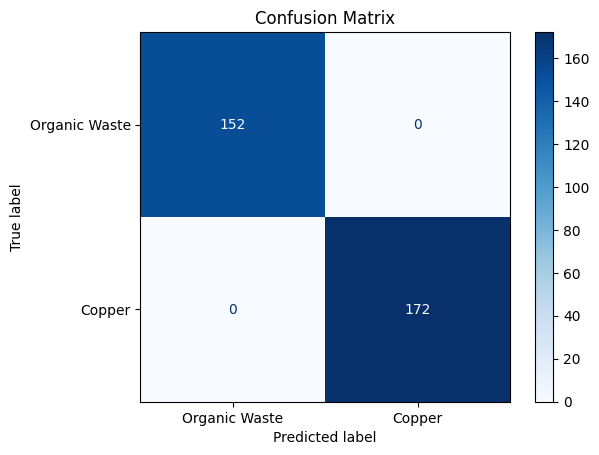

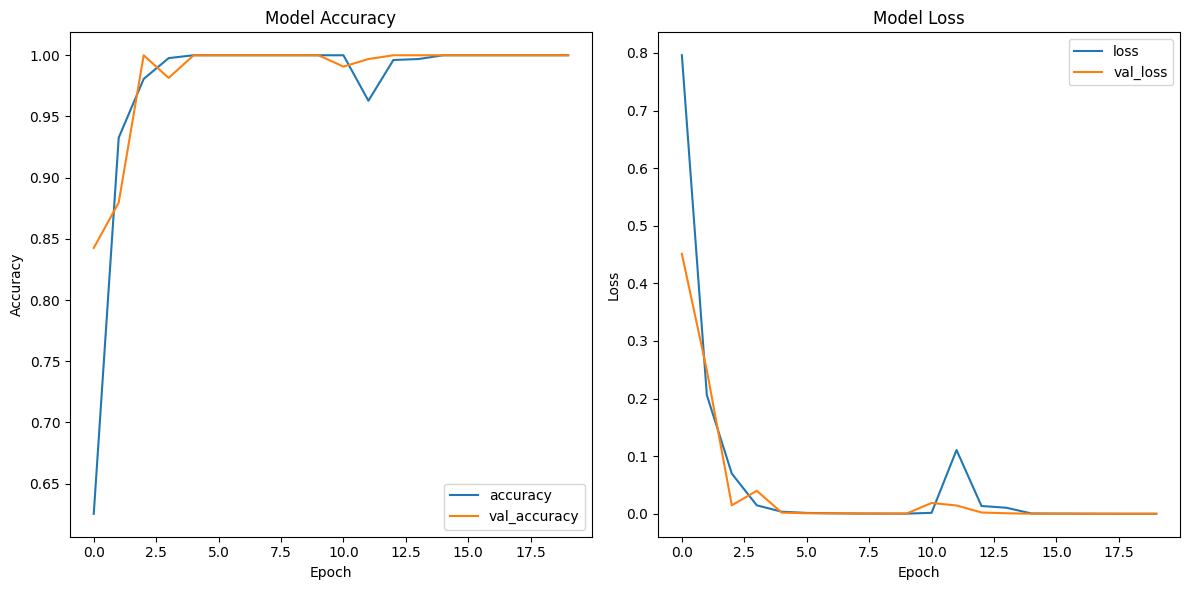

In [27]:


# Evaluate the model
loss, accuracy = model.evaluate(X_test_aug, y_test_aug_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict the labels for the test set
y_pred_prob = model.predict(X_test_aug)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_aug_cat, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Organic Waste', 'Copper']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=['Organic Waste', 'Copper']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')

plt.tight_layout()
plt.show()
